<h2 style='color:blue' align='center'>Small Image Classification Using Convolutional Neural Network (CNN)</h2>

In this notebook, we will classify small images cifar10 dataset from tensorflow keras datasets. There are total 10 classes as shown below. We will use CNN for classification

***Code 1***

In [ ]:
import os
# Define a directory to save preprocessed data
PREPROCESSED_DATA_DIR = "preprocessed_data"

# Ensure the directory exists
os.makedirs(PREPROCESSED_DATA_DIR, exist_ok=True)

# Function to load and preprocess data
def load_and_preprocess_data(process_id):
    # Load CIFAR-10 dataset
    (X_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

    # Preprocess data (normalize pixel values to range [0, 1] and convert labels to one-hot encoding)
    X_train = X_train.astype('float32') / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

    # Save preprocessed data to disk
    np.savez_compressed(os.path.join(PREPROCESSED_DATA_DIR, f'data_{process_id}.npz'), X_train=X_train, y_train=y_train)

    # Return the path to the preprocessed data file
    return os.path.join(PREPROCESSED_DATA_DIR, f'data_{process_id}.npz')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import os

# Set the environment variable
os.environ['OMP_NUM_THREADS'] = '2'


# Define MiniXception model using PyTorch
class MiniXception(nn.Module):
    def __init__(self, num_classes):
        super(MiniXception, self).__init__()
        # Define layers similar to the Keras implementation
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.middle_flow = self._make_middle_flow(64)
        self.exit_flow = self._make_exit_flow(64, 128)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_middle_flow(self, channels):
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def _make_exit_flow(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),         # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define your batch size
batch_size = 64

# Define your training data loader with multi-threading enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Specify the number of epochs for training
num_epochs = 20

# Initialize MiniXception model
model = MiniXception(num_classes=10)

# Check if CUDA is available and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available() :
  print('cuda')
if torch.cuda.device_count() == 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

# Print model summary
summary(model, (3, 32, 32))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
import time

# Train the model
for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time of the epoch
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    epoch_time = time.time() - start_time  # Calculate epoch time
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} seconds")

print('Finished Training')

100%|██████████| 170498071/170498071 [00:13<00:00, 12565243.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


cuda
Let's use 1 GPUs!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/20], Loss: 1.3914, Accuracy: 49.18%, Time: 36.80 seconds
Epoch [2/20], Loss: 1.0095, Accuracy: 63.75%, Time: 33.76 seconds
Epoch [3/20], Loss: 0.8466, Accuracy: 70.09%, Time: 34.05 seconds
Epoch [4/20], Loss: 0.7385, Accuracy: 74.07%, Time: 35.27 seconds
Epoch [5/20], Loss: 0.6607, Accuracy: 76.66%, Time: 33.57 seconds
Epoch [6/20], Loss: 0.5937, Accuracy: 79.32%, Time: 34.12 seconds
Epoch [7/20], Loss: 0.5371, Accuracy: 81.32%, Time: 33.37 seconds
Epoch [8/20], Loss: 0.4906, Accuracy: 82.98%, Time: 33.84 seconds
Epoch [9/20], Loss: 0.4517, Accuracy: 84.50%, Time: 33.53 seconds
Epoch [10/20], Loss: 0.4159, Accuracy: 85.78%, Time: 33.50 seconds
Epoch [11/20], Loss: 0.3851, Accuracy: 86.71%, Time: 34.13 seconds
Epoch [12/20], Loss: 0.3552, Accuracy: 87.51%, Time: 33.33 seconds
Epoch [13/20], Loss: 0.3266, Accuracy: 88.56%, Time: 34.05 seconds
Epoch [14/20], Loss: 0.3052, Accuracy: 89.43%, Time: 33.89 seconds
Epoch [15/20], Loss: 0.2831, Accuracy: 90.17%, Time: 33.87 seconds
Epoc

***Code 2***

<img src="small_images.jpg" />

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

<h4 style="color:purple">Load the dataset</h4>

In [ ]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
X_train.shape

170498071/170498071 [==============================] - 13s 0us/step


(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

Here we see there are 50000 training images and 1000 test images

In [ ]:
y_train.shape

(50000, 1)

In [ ]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

y_train is a 2D array, for our classification having 1D array is good enough. so we will convert this to now 1D array

In [ ]:
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [ ]:
y_test = y_test.reshape(-1,)

In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Let's plot some images to see what they are

In [ ]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

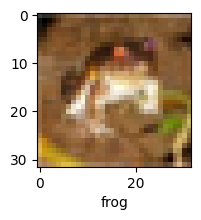

In [ ]:
plot_sample(X_train, y_train, 0)

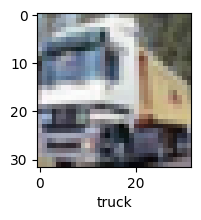

In [ ]:
plot_sample(X_train, y_train, 1)

Normalize the images to a number from 0 to 1. Image has 3 channels (R,G,B) and each value in the channel can range from 0 to 255. Hence to normalize in 0-->1 range, we need to divide it by 255

<h4 style="color:purple">Normalizing the training data</h4>

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

<h4 style="color:purple">Now let us build a convolutional neural network to train our images</h4>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def MiniXception(input_shape, num_classes):

    # Use MirroredStrategy for synchronous distributed training
    strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():
        inputs = Input(shape=input_shape)

        # Entry Flow
        x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Middle Flow
        for _ in range(4):
            residual = x
            x = SeparableConv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = SeparableConv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = layers.add([x, residual])

        # Exit Flow
        x = SeparableConv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = GlobalAveragePooling2D()(x)

        # Fully connected layer
        x = Dense(64, activation='relu')(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model

# Initialize MiniXception
cnn = MiniXception(input_shape=(32, 32, 3), num_classes=10)
cnn.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 32)           0         ['batch_normalization[0][0

In [ ]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelEncoder

# Convert labels to numerical encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.ravel())

# Split data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Create Dask arrays for training data
X_train_dask = da.from_array(X_train_split, chunks='auto')
y_train_dask = da.from_array(y_train_split, chunks='auto')

if tf.test.gpu_device_name():
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    with tf.device('/GPU:0'):
        cnn.fit(X_train_dask, y_train_dask, epochs=20)
else:
    print("GPU not found. Training on CPU.")
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train_dask, y_train_dask, epochs=20)


Epoch 1/20
1250/1250 [==============================] - 48s 28ms/step - loss: 1.4403 - accuracy: 0.4662
Epoch 2/20
1250/1250 [==============================] - 36s 29ms/step - loss: 1.0655 - accuracy: 0.6161
Epoch 3/20
1250/1250 [==============================] - 36s 29ms/step - loss: 0.9212 - accuracy: 0.6724
Epoch 4/20
1250/1250 [==============================] - 35s 28ms/step - loss: 0.8211 - accuracy: 0.7108
Epoch 5/20
1250/1250 [==============================] - 36s 29ms/step - loss: 0.7472 - accuracy: 0.7404
Epoch 6/20
1250/1250 [==============================] - 36s 29ms/step - loss: 0.6798 - accuracy: 0.7627
Epoch 7/20
1250/1250 [==============================] - 35s 28ms/step - loss: 0.6286 - accuracy: 0.7784
Epoch 8/20
1250/1250 [==============================] - 36s 29ms/step - loss: 0.5815 - accuracy: 0.7969
Epoch 9/20
1250/1250 [==============================] - 35s 28ms/step - loss: 0.5428 - accuracy: 0.8102
Epoch 10/20
1250/1250 [==============================] - 36s 29m

In [18]:
cnn.evaluate(X_test,y_test)

313/313 [==============================] - 4s 11ms/step - loss: 1.0906 - accuracy: 0.7033


[1.090557336807251, 0.7032999992370605]

In [19]:
y_pred = cnn.predict(X_test)
y_pred[:5]

313/313 [==============================] - 3s 8ms/step


array([[9.00838641e-05, 3.51352523e-11, 2.30172592e-08, 9.56921697e-01,
        6.79951953e-08, 4.29600999e-02, 2.79238520e-05, 6.45672813e-08,
        7.62496555e-09, 2.25187091e-11],
       [7.93205459e-07, 2.30605601e-05, 4.41996717e-11, 1.07072878e-10,
        7.42644314e-12, 2.97492152e-12, 1.38460687e-09, 2.04778428e-13,
        9.99975681e-01, 4.55132692e-07],
       [4.66552505e-04, 1.00667557e-05, 6.74259525e-07, 9.88894726e-07,
        1.43988865e-08, 1.54240894e-07, 5.41814757e-07, 2.61980261e-07,
        9.99514937e-01, 5.80713140e-06],
       [6.47388518e-01, 7.08544712e-06, 3.24800494e-03, 1.47640108e-04,
        5.34030318e-04, 1.97410976e-04, 2.53635117e-05, 1.36434719e-05,
        3.48417222e-01, 2.11185688e-05],
       [1.09442010e-06, 4.13360198e-07, 4.10859269e-04, 2.08336618e-02,
        1.08727836e-04, 7.79641559e-05, 9.78567004e-01, 2.59229593e-09,
        3.43383164e-07, 4.85947060e-09]], dtype=float32)

In [20]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[3, 8, 8, 0, 6]

In [21]:
y_test[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

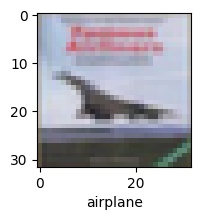

In [22]:
plot_sample(X_test, y_test,3)

In [23]:
classes[y_classes[3]]

'airplane'

In [24]:
classes[y_classes[3]]

'airplane'